In [104]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import cv2 
from glob import glob
from astropy.io import fits
from photutils import centroid_sources, centroid_com, centroid_quadratic

### Calculating bias

In [3]:
#function to get the data from fits files
def get_data(file):
    foo = fits.open(file)
    return foo[0].data

In [4]:
def open_fits(directory):
    files =[]
    for filename in os.listdir(directory):
        if filename.endswith(".fits"):
              foo = fits.open(directory + '/' + filename)[0]
              files.append(foo)
    return files

In [5]:
#function to calculate bias average value and standard deviation
#code credit: https://stackoverflow.com/questions/10377998/how-can-i-iterate-over-files-in-a-given-directory
def bias_calc(directory):
    averages = []
    stds = []
    for filename in os.listdir(directory):
        if filename.endswith(".fits"):
              averages.append(get_data(directory + '/' + filename).mean())
              stds.append(get_data(directory + '/' + filename).std())
    avg = np.array([averages])
    stan = np.array([stds])
    mean = avg.mean()
    std = stan.mean()
    return mean,std

In [6]:
#directories for the bias data
bias_directory_008 = 'data/darks/0.008'
bias_directory_009 = 'data/darks/0.009'

In [7]:
#biases for 0.008 s and 0.009 s exposures 
bias_008,std_008 = bias_calc(bias_directory_008)
bias_009,std_009 = bias_calc(bias_directory_009)

In [8]:
print(bias_008)
print(std_008)
print(bias_009)
print(std_009)

766.3802704883889
28.476783627343334
766.4963268640007
28.424245044490817


### Jupiter Data

In [9]:
jupiter_directory = 'data/jupiter'

In [10]:
#put all our images in a single array of arrays. Then we can access each individual image using index
def multiple_fits(directory):    
    images = []
    for filename in os.listdir(directory):
        images.append(get_data(directory + '/' + filename))
    data = np.array(images)
    return data

In [11]:
jupiter_data = multiple_fits(jupiter_directory)

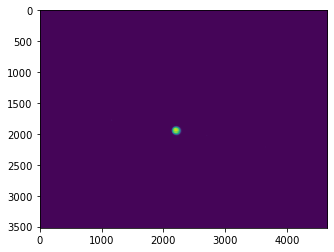

In [49]:
#the first image
plt.imshow(jupiter_data[0])

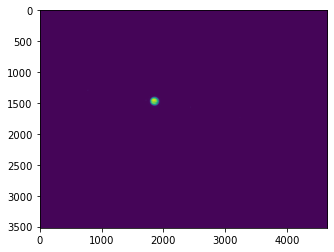

In [50]:
plt.imshow(jupiter_data[21])

In [192]:
jupiter_data = jupiter_data - bias_008

In [193]:
#calculating the centroid of the reference image
x0, y0 = centroid_quadratic(jupiter_data[0], fit_boxsize = 1000)
print(x0,y0)

2198.6748305827 1941.4548058509636


In [194]:
#calculate centroids of the rest of the images and put them in arrays
def calculate_centroids(data):
    xcoor = []
    ycoor = []
    for child in data[1:]:
        x,y = centroid_quadratic(child, fit_boxsize = 1000)
        xcoor.append(x)
        ycoor.append(y)
    xcen = np.array(xcoor)
    ycen = np.array(ycoor)
    return xcen,ycen

In [195]:
centroids_x,centroids_y = calculate_centroids(jupiter_data)

In [196]:
#calculating positional offsets compared to the reference image
xoffset =  -(centroids_x - x0)
yoffset =  -(centroids_y - y0)

In [197]:
xoffset

array([ 32.95135038,  55.6734321 ,  74.96988243, 111.62709168,
       128.27346698, 156.25114497, 186.46214335, 218.37685254,
       264.1243004 , 282.82268273, 300.50792316, 335.11586839,
       351.75151372, 363.35780234, 377.12516025, 386.65404679,
       390.48152795, 392.22020898, 386.23340337, 365.3923367 ,
       356.51082789])

In [198]:
#constructing a linear transformation matrices to be applied to source images
def transformation_matrices(xoffset,yoffset,):
    m = []
    for i in range(len(xoffset)):
        foo = np.array([[1, 0, xoffset[i]], [0, 1, yoffset[i]]]) 
        m.append(foo)
    M = np.array(m)
    return M

In [199]:
lintrans = transformation_matrices(xoffset,yoffset)
lintrans[0]

array([[  1.        ,   0.        ,  32.95135038],
       [  0.        ,   1.        , -14.51444314]])

In [200]:
rows, cols = jupiter_data[0].shape[:2] 

In [201]:
#shifting the rest of the images by offsets in comparison with the reference image
def image_registration(data,M,rows,cols):
    res = []
    for i in range(1,len(data)):
        foo = cv2.warpAffine(jupiter_data[i], M[i-1], (cols, rows)) 
        res.append(foo)
    out = np.array(res)
    return out

In [202]:
new_jupiter_data = image_registration(jupiter_data,lintrans,rows,cols)

In [203]:
#if we need to actually write the files back to fits. Headers are not preserved unfortunately, might solve this later if needed
def write_to_fits(directory,data):
    name = 'jupiter'
    fitslist = []
    for i in range(len(data)):
        foo = fits.PrimaryHDU(data[i])
        fitslist.append(foo)
    for i in range(len(fitslist)):    
        fitslist[i].writeto(directory + '/' + name + str(i) + '.fits')   

In [204]:
ref_img = np.array(jupiter_data[0])
ref_img.shape

(3520, 4656)

In [205]:
#getting out new dataset together
jupiter_centred_data = np.concatenate(([ref_img], new_jupiter_data))

In [209]:
#uncomment if you need to write the centred images to .fits files
#jupiter_centred = 'data/jupiter_centred'
#write_to_fits(jupiter_centred,jupiter_centred_data)

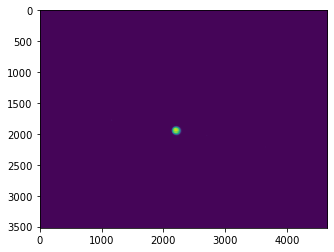

In [210]:
plt.imshow(jupiter_centred_data[0])

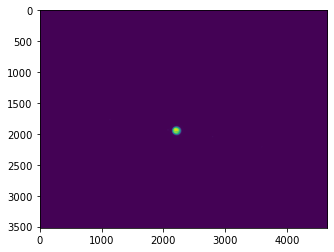

In [211]:
plt.imshow(jupiter_centred_data[21])